<a href="https://colab.research.google.com/github/Satorresja/COVID-19/blob/master/Covid_Prediction_in_Colombia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#descargar datos covid
!pip install wget
import wget
import pandas as pd
#datos covid19 - mundo
url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#datos Colombia
#url = "https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD"
wget.download(url, 'covid.csv')
Xd = pd.read_csv('covid.csv')
Xd

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=9e047694ec0d408f2342a706894172e333b1a0742f1dbacda88aac03ad009e34
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,14,16,16,16,23,174,174,187,208
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,6,7,10,10,12,22,25,25,34
264,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,3,8,8,8


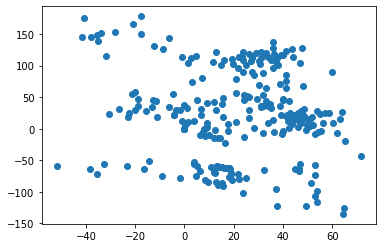

In [2]:

import numpy as np
import matplotlib.pyplot as plt
plt.scatter(Xd['Lat'],Xd['Long'])

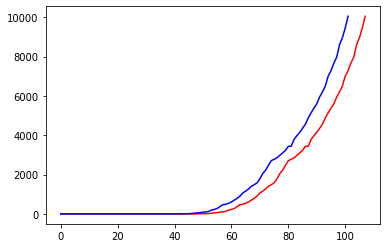

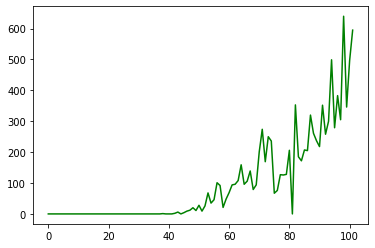

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:
      X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
      y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
      pi += 1
      pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N


ii = Xd[Xd.columns[1]] == 'Colombia'
#print(np.where(ii)[0][0])
#contagios  acumulados
serie = np.array(Xd.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))
w = 5
X,y = covid_win(serie,w=w)
X_d,y_d = covid_win(serie_d,w=w)

plt.plot(serie,'r')
plt.plot(y,'b')
plt.show()
plt.plot(y_d,'g')



# Entrenamiento de regresor para covid 19 - Colombia
# Análisis exploratorio - visualización en 2D PCA
# Validación cruzada y anidada (pocos datos)

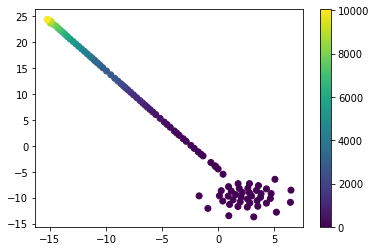

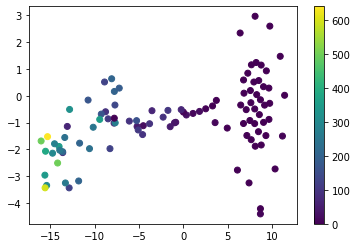

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

red = TSNE(n_components = 2,perplexity=10)
red_d = TSNE(n_components = 2,perplexity=10)

#red = PCA()
#red_d = PCA()


z = red.fit_transform(X)
z_d = red_d.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()


plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()


$$y_{new}=reg(red(scaler(x_{new})))$$

fit: entrenamiento, ajuste, aprende los parámetros utilizando los hyperparámetros fijados

Ej: red = PCA(n_components = 0.9); n_components hyperparameter

$$W^*=\arg \max_W W^\top X^\top X W\\
\quad \rm{s.t.} \quad W^\top W = I$$

$$ red(scaler(x_{new})) = scaler(x_{new})W$$ mapeo de PCA

mapeo - operacion: transformacion y predicción. Predicción es la última etapa en steps -> regresor

transformacion: scaler y rep (PCA)

Si mi modelo no tiene transformacion, no puedo utilizarlo en nuevos datos

Utilizar regresor: por vecindad -> KNN, K- nearest neighbors

# Clase custom tsne con mapeo de puntos nuevos por vecinos más cercanos

$$z_{new} = \sum_{n=1}^K w_{n,new} z_n = w_{n,new}^\top Z; \quad z_n \in \Omega_{new}$$

$$\Omega_{new} \in \mathbb{R} ^{K \times P}$$ los K-vecinos mas cercanos de $x_{new}$ en  $X_{train}$

$$ \sum_{n=1}^K w_{n,new}=1$$, preservar noción de probabilidad, combianción lineal convexa.

$$w_{n,new} = \frac{\exp\left(-\frac{\|x_n - x_{new}\|^2_2}{2\sigma^2}\right)}{\sum_{n'=1}^K w_{n',new}}$$



In [0]:
from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor
class tsne_map(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, n_components = 2,perplexity=10, n_neighbors = 10): #constructor clase con hyperparámetros
        self.n_components = n_components
        self.perplexity = perplexity
        self.n_neighbors = n_neighbors
        return None

    def fit(self,X,*_): #entrenamiento, primero se hace tsne y luego se entrena el regresor knn para llevar del espacio X as Z
        red = TSNE(n_components = self.n_components,perplexity=self.perplexity)
        z = red.fit_transform(X)

        self.neigh = KNeighborsRegressor(n_neighbors=self.n_neighbors) 
        self.neigh.fit(X, z) #entrenamiento knn, se guarda en la clase
        return self
    def transform(self,X,*_):
       return self.neigh.predict(X) #evaluar en puntos nuevos-> transform o predict

    def fit_transform(self,X,*_): #entrenar y evaluar, solo para caso xtrain y ztrain
        self.fit(X)
        red = TSNE(n_components = self.n_components,perplexity=self.perplexity)
        return self.transform(X)#red.fit_transform(X)

In [6]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
#pocos datos y mucha incertidumbre, validación cruzada anidada
Xdata, ydata = X,y #acumulado contagiados
#Xdata, ydata = X_d,y_d # contagiados x dia
X_train, X_test, y_train, y_test = train_test_split(Xdata,ydata,test_size=0.3) 
print(X_train.shape)
print(X_test.shape)

(71, 5)
(31, 5)


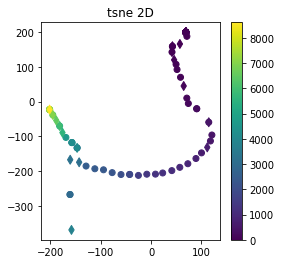

In [7]:
#ejemplo de uso clase custom tsne
red = tsne_map()
z_train = red.fit_transform(X_train)
z_test = red.transform(X_test) #mapear test

plt.figure(figsize=(4,4))
plt.scatter(z_train[:,0],z_train[:,1],c=y_train)
plt.scatter(z_test[:,0],z_test[:,1],c=y_test,s=40,marker='d')
plt.colorbar()
plt.title('tsne 2D')
plt.show()

In [0]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as msa



steps = [
         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'poly'))], #clasificador 
         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('rep', PCA()),  #pueden utilizar clase generada tsne_map()
          ('reg', KNeighborsRegressor())]
         ]        

#parametros a buscar por busqueda por grilla
parameters =[
             {'reg__gamma':[1e-3,1e-2,1e-1,1,10],
             'reg__alpha':[1e-3,1e-2,1e-1,1,10]
             },
             {
              'reg__n_neighbors': [1,3,5], #parametros n_neighbors debe ser siempre un int
              'rep__n_components':[0.5,0.75,0.9]
             }
              ]

label_model = ['NorSC-KRRBF','NorSC-PCA-KNN']


In [9]:
#valildacion cruzada anidada
Niter = 10 #numero particiones outter loop nested cross-validation
msev =np.zeros((Niter,len(steps)))#arreglo para guardar acierto
Nmod = len(steps) #numero de modelos a probar
best_estimators = Niter*[None]#mejor metodo por iteracion
###clave del funcionamiento
best_hyperpar = Niter*[None]#mejor metodo por iteracion 
#############################
for j in range(Niter): #outter loop
      #print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(Xdata,ydata,test_size=0.3) # xtrain 60, xtest 26
      list_est = [] #lista lazo interno para guardar mejor estimador por modelo para iteracion j
      list_hyper = [] #lista lazo interno para guardar mejores hyperparametros por modelo para iteracion j
      for r in range(Nmod): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=5,scoring='neg_mean_absolute_error',n_jobs=5) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          #guardar mejor modelo
          list_est.append(grid_search.best_estimator_)
          list_hyper.append(grid_search.best_params_)
          #guardar acierto
          msev[j,r] = msa(y_test,y_pred)
          print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r+1,len(steps)))
          print('best hyper', grid_search.best_params_)
          print('msa:',msev[j,r])
          
      best_estimators[j] = list_est #guardar mejores modelos 
      best_hyperpar[j] = list_hyper #mejores hyperparametros
          
          
      savedata = {
          'acc':msev,
          'best_models':best_estimators,
          'best_parameters':best_hyperpar,
            } 
      dump(savedata,'covid19_1.joblib')
      

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    3.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 1/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1}
msa: 72.97165239857785
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s


it 1/10-Modelo 2/2
best hyper {'reg__n_neighbors': 3, 'rep__n_components': 0.5}
msa: 85.65591397849467
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


it 2/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01}
msa: 74.38970339042181
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s


it 2/10-Modelo 2/2
best hyper {'reg__n_neighbors': 1, 'rep__n_components': 0.5}
msa: 127.70967741935483
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


it 3/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01}
msa: 46.98537734392049
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s


it 3/10-Modelo 2/2
best hyper {'reg__n_neighbors': 3, 'rep__n_components': 0.5}
msa: 38.720430107526894
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


it 4/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1}
msa: 39.43969535934464
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s


it 4/10-Modelo 2/2
best hyper {'reg__n_neighbors': 3, 'rep__n_components': 0.5}
msa: 43.05376344086023
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done 116 out of 125 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s


it 5/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1}
msa: 42.11413023177298
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s


it 5/10-Modelo 2/2
best hyper {'reg__n_neighbors': 3, 'rep__n_components': 0.5}
msa: 48.892473118279575
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s


it 6/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1}
msa: 64.48526869833947
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s


it 6/10-Modelo 2/2
best hyper {'reg__n_neighbors': 1, 'rep__n_components': 0.5}
msa: 154.8709677419355
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s


it 7/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01}
msa: 44.01173664394657
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


it 7/10-Modelo 2/2
best hyper {'reg__n_neighbors': 1, 'rep__n_components': 0.5}
msa: 111.3225806451613
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s


it 8/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01}
msa: 72.70253406518567
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s


it 8/10-Modelo 2/2
best hyper {'reg__n_neighbors': 1, 'rep__n_components': 0.5}
msa: 219.1290322580645
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s


it 9/10-Modelo 1/2
best hyper {'reg__alpha': 0.1, 'reg__gamma': 1}
msa: 67.83523407214051
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Done  36 out of  45 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s


it 9/10-Modelo 2/2
best hyper {'reg__n_neighbors': 3, 'rep__n_components': 0.5}
msa: 72.34408602150539
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s


it 10/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01}
msa: 62.64430704857448
Fitting 5 folds for each of 9 candidates, totalling 45 fits
it 10/10-Modelo 2/2
best hyper {'reg__n_neighbors': 3, 'rep__n_components': 0.5}
msa: 72.48387096774194


[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    0.2s finished


$$w^* = (\Phi^\top \Phi + \lambda I)^{-1}\Phi^\top y $$

$$y_n = \phi_n w^*$$


$\lambda$: hyperparameter

$\Phi(x)=\mathcal{N}(x|\mu,\sigma^2)$

$\mu,\sigma$ hyperparameters

$w$: model's parameter

Por Niter de outter loop tengo valores de los hyperparameters, Ej:

$$\gamma = [0.01,0.1,10,1000,10000,0.01]$$

$$\gamma = [0.01,0.01,0.01,0.1,1,0.01]$$

$$\gamma^* = {\rm{mode}}(\gamma_i) = 0.01$$

Toma todos los datos los N, entreno sobre todo el conjunto con los hyperparametros encontrados utilizando validación cruzada anidada $\gamma^*$

$$w^* =f(X|\gamma^*)$$

$$ y_{new} = f(x_{new}|\gamma^*,w^*)$$

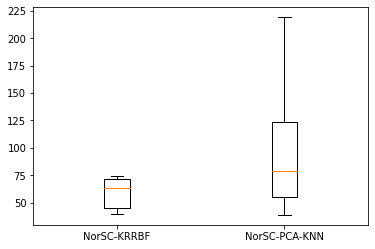

In [10]:
plt.boxplot(msev)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model)
plt.show()

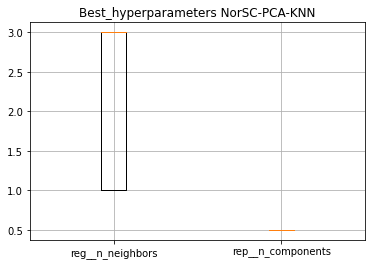

Modes=  [3.  0.5]


In [11]:
from scipy.stats import mode
from datetime import date

r = 1 #hyperparameters model 1
nh = len(best_hyperpar[0][r])
hyperpar_r = np.zeros((Niter,nh)) 
for i in range(Niter):
  for j in range(nh):
    hyperpar_r[i,j] = best_hyperpar[i][r].get(list(best_hyperpar[i][r].keys())[j])
    
    
#revisar numero entero para realizar casting
aa = list(best_hyperpar[0][r].keys())
c = -1
for i in range(len(aa)):
    if aa[i].find('n_neighbors') > -1:
      c = i

plt.boxplot(hyperpar_r)
plt.xticks(ticks=np.arange(nh)+1,labels=list(best_hyperpar[0][r].keys()))
plt.title('Best_hyperparameters '+label_model[r])
plt.grid()
plt.show()

mode_hyper = mode(hyperpar_r,axis=0)[0][0]
print("Modes= ", mode_hyper)




In [12]:
#entrenar con mejores hyperparametros
model_f = Pipeline(steps[r])
paramsf = parameters[r]
hyperl = list(parameters[r].keys())
nh = len(hyperl)
for j in range(nh):
  if j == c: 
    paramsf[hyperl[j]] = int(mode_hyper[j])
  else:
     paramsf[hyperl[j]] = mode_hyper[j] 

model_f.set_params(**paramsf)
model_f.fit(Xdata,ydata) #entrenar con todos los datos porque no tenemos suficientes > 10000 entrenar xtrain de lo contrario con todo el dataset

print('Predicción contagiados covid19 ',date.today(),'=',model_f.predict(serie[len(serie)-w:].reshape(1,-1))[0])

Predicción contagiados covid19  2020-05-10 = [9488.66666667]


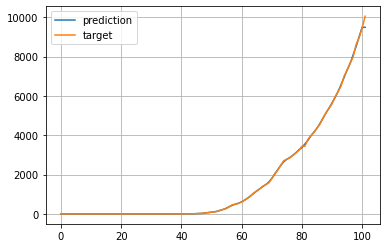

In [13]:
#curva predicción sobre modelo  final
plt.plot(model_f.predict(Xdata),label='prediction')
plt.plot(ydata,label='target')
plt.grid()
plt.legend()
plt.show()